In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pylab as pl
from scipy import stats
import warnings
from itertools import product
from dateutil.relativedelta import *
import datetime
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [2]:
sm.__version__

'0.11.0'

# Анализ данных о среднемесячных уровнях заработной платы в России

Для выполнения этого задания вам понадобятся данные о среднемесячных уровнях заработной платы в России.
В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. 

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.


Придерживайтесь стандартного алгоритма построения прогноза:

* Визуальный анализ ряда
* Стабилизация дисперсии (при необходимости)
* Выбор порядка дифференцирования
* Выбор начальных приближений для p, q, P, Qp,q,P,Q
* Обучение и сравнение моделей-кандидатов, выбор победителя
* Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p, q, P, Qp,q,P,Q.
* Прогнозирование с помощью финальной модели.

Сдать необходимо ipython-ноутбук с проведённым анализом; пожалуйста, комментируйте в ноутбуке каждый важный шаг построения модели.

In [3]:
data = pd.read_csv('WAG_C_M.csv', sep=';',index_col=['month'],parse_dates=['month'], dayfirst=True)
print(data.info())
data.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 284 entries, 1993-01-01 to 2016-08-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   WAG_C_M  284 non-null    float64
dtypes: float64(1)
memory usage: 4.4 KB
None


,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


## Визуальный анализ и проверка стационарности
Проведем визуальный анализ ряда, проверим его на  стационарности и построим STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


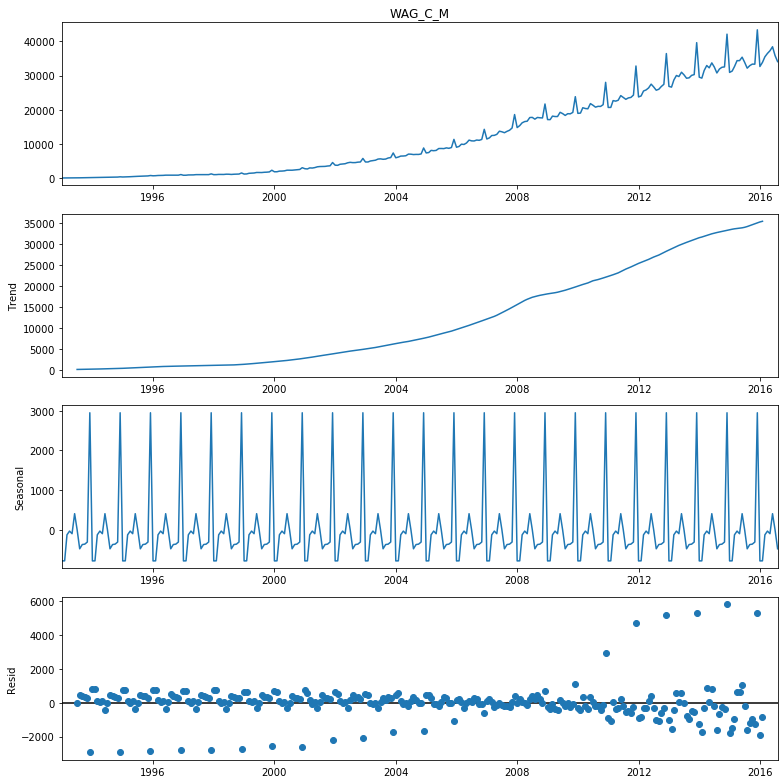

In [4]:
pl.rcParams['figure.figsize'] = 11, 11
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M.dropna())[1])
plt.show()

Критерий Дики-Фуллера отверг гипотезу о том, что я ряд не стационарен, что также видно по графикам. Присутствует ярко-выраженный тренд и сезонность

## Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.991850


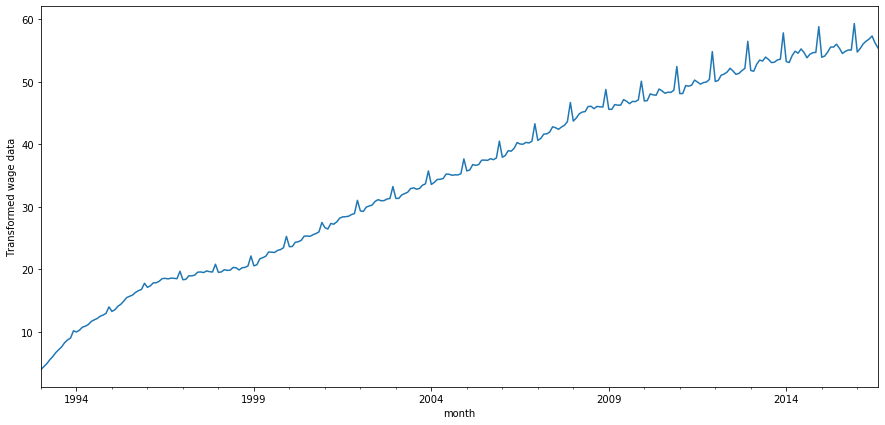

In [5]:
data['WAG_box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize=(15,7))
data.WAG_box.plot()
plt.ylabel(u'Transformed wage data')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

Критерий Дики-Фуллера также отвергает гипотезу о стационарности ряда, поэтому посчитаем первые разности ряда, а также проведем сезонное дифференцирование, так как присутствует годовая сезонность, которая видна на графиках. 

In [6]:
data['WAG_diff1'] = data.WAG_box - data.WAG_box.shift(1)
data['WAG_diff12'] = data.WAG_box - data.WAG_box.shift(12)
data['WAG_diff1_12'] = data['WAG_diff12'] - data.WAG_diff12.shift(1)

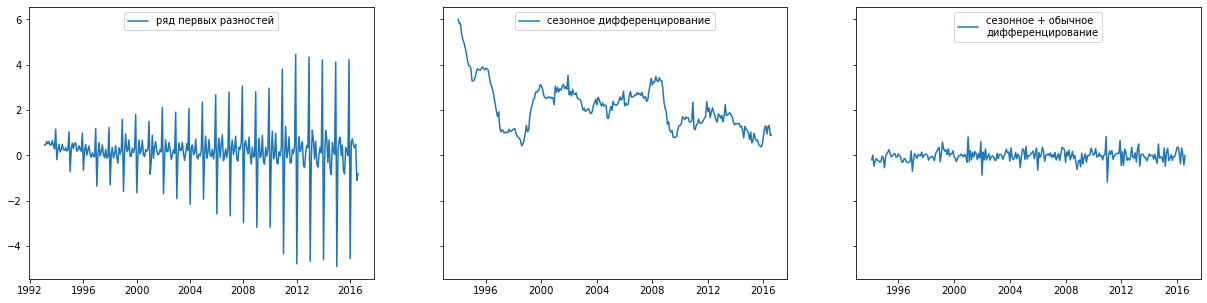

In [7]:
fig, ax = plt.subplots(1,3, figsize=(21,5), sharey=True)
ax[0].plot(data['WAG_diff1'])
ax[0].legend(['ряд первых разностей'],loc="upper center")
ax[1].plot(data['WAG_diff12'])
ax[1].legend(['сезонное дифференцирование'],loc="upper center")
ax[2].plot(data['WAG_diff1_12'])
ax[2].legend(['сезонное + обычное \nдифференцирование'],loc="upper center")
plt.show()

Видно, что последовательное сезонное и обычное дифференцирование делает ряд помогает избавиться от тренда и сезонности. Проверим это - сделаем STL-декомпозицию

Критерий Дики-Фуллера: p=0.000000


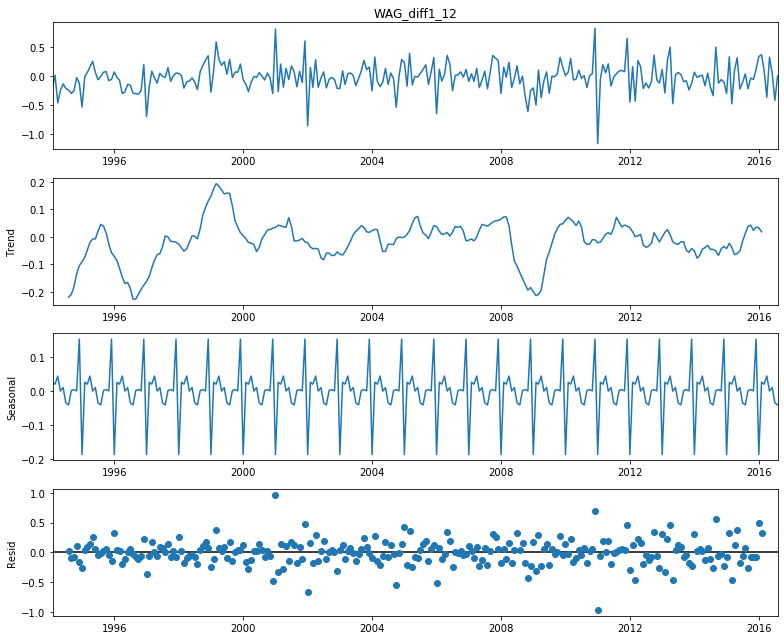

In [8]:
pl.rcParams['figure.figsize'] = 11, 9
sm.tsa.seasonal_decompose(data.WAG_diff1_12.dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_diff1_12.dropna())[1])
plt.show()

Гипотеза нестационарности отвергается, ряд стационарен, и визуально  тренда больше нет.

## Подбор модели

Для подбор первого приближения параметров модели посмотрим на АКФ и ЧАКФ временного ряда

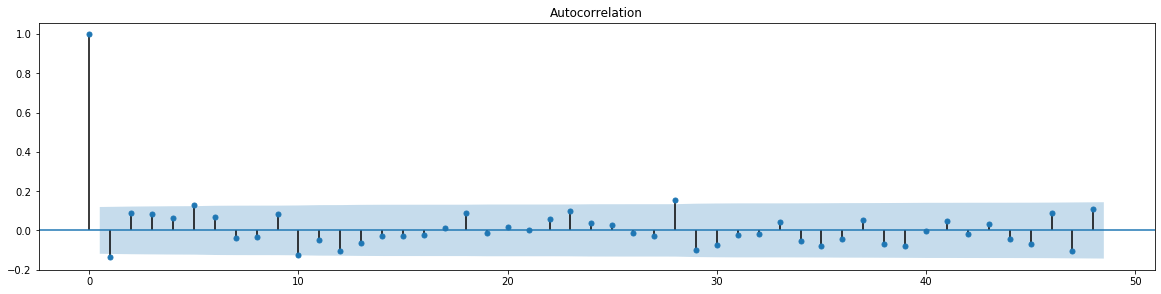

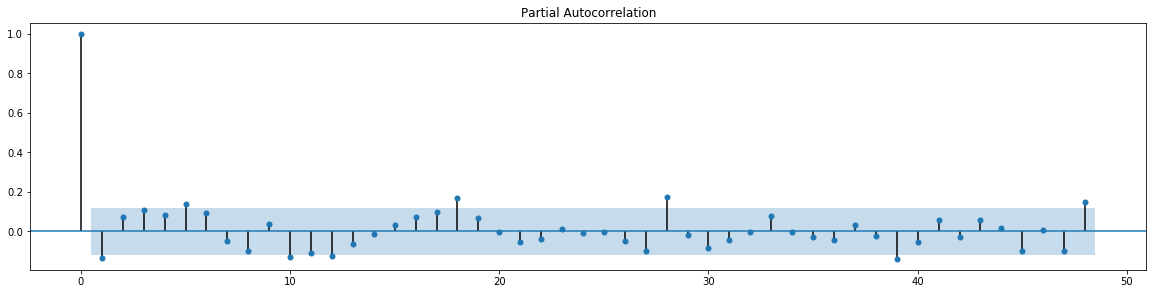

In [9]:
plt.figure(figsize=(20,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.WAG_diff1_12[13:], lags=48, ax=ax)
pl.show()
plt.figure(figsize=(20,10))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.WAG_diff1_12[13:], lags=48, ax=ax)
pl.show()

В качестве начальных приближений выберем Q=0, q=1, P=0, p=1

In [10]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [11]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

Выберем лучшую модель посредством перебора по критерию AIC

In [12]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.WAG_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 8.69 s


In [13]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            WAG_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Thu, 27 Feb 2020   AIC                              0.341
Time:                                    18:09:31   BIC                             11.147
Sample:                                01-01-1993   HQIC                             4.679
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

Посмотрим на остатки модели и проверим их на стационарность и нормальность

Критерий Стьюдента: p=0.090793
Критерий Дики-Фуллера: p=0.000003


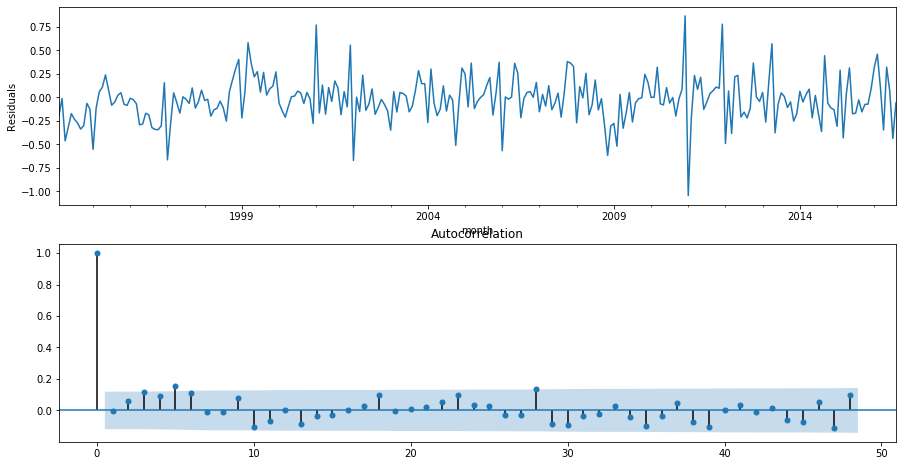

In [14]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). 

Посмотрим, насколько хорошо модель описывает данные:

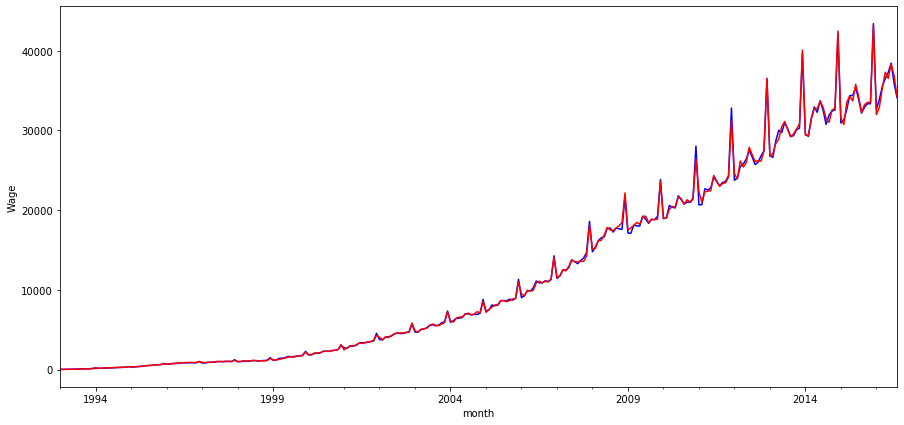

In [15]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
data.WAG_C_M.plot(color='b')
data.model.plot(color='r')
plt.ylabel('Wage')
pl.show()

## Прогноз

Построим прогноз с помощью выбранной модели

In [16]:
print(max(data.index))
print(data.shape)

2016-08-01 00:00:00
(284, 6)


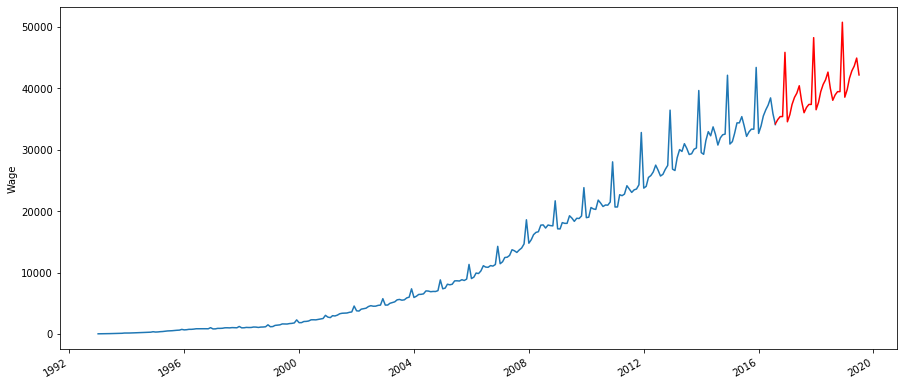

In [21]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime(
    "2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0, 36)]
future = pd.DataFrame(index=date_list, columns=data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=283, end=320), lmbda)

plt.figure(figsize=(15, 7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('Wage')
pl.show()